## Visualization Tool

In [50]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n.operator:
            dot.node(name=str(id(n)) + n.operator, label=n.operator)
            dot.edge(str(id(n)) + n.operator, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

## Tensor

In [51]:
import random
import math

class Tensor:
    def __init__(self, value, label='', children=(), operator=None):
        self.value = value
        self.children = set(children)
        self.operator = operator
        self.grad = 0
        self._backward = lambda: None
        self.label = label

    def __repr__(self) -> str:
        return f"Tensor(value={self.value})"

    def __mul__(self, other):
      other = other if isinstance(other, Tensor) else Tensor(other)

      out = Tensor(self.value*other.value, children= (self, other), operator='*')

      def backward():
        self.grad += other.value * out.grad
        other.grad += self.value * out.grad

      out._backward = backward

      return out

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        out = Tensor(self.value + other.value, children=(self, other), operator='+')

        def backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = backward

        return out

    def __pow__(self, other):
        input_value = self.value
        output_value = math.pow(input_value, other)

        out = Tensor(output_value, children=(self,), operator='pow')

        def backward():
            self.grad += other * math.pow(self.value, other - 1) * out.grad

        out._backward = backward
        return out

    def __sub__(self, other):
      return self + (-other)

    def backward(self):
      topo_sort = []
      visited_set = set()
      def build_topo(v):
        for child in v.children:
          if child not in visited_set:
            visited_set.add(v)
            build_topo(child)
        topo_sort.append(v)
      build_topo(self)

      for i in reversed(topo_sort):
        i._backward()



class F:

  def sigmoid(x):
    return 1 / (1 + math.exp(-x))

  def dsigmoid(x):
    return F.sigmoid(x) * (1 - F.sigmoid(x))

  def silu(x):
    return x * F.sigmoid(x)

  def dsilu(x):
    return F.sigmoid(x) + x * F.dsigmoid(x)

  @staticmethod
  def silu_function(x) -> Tensor:
    x = x if isinstance(x, Tensor) else Tensor(x)
    out = Tensor(F.silu(x.value) , children=(x, ), operator='silu')

    def backward():
      x.grad += F.dsilu(x.value) * out.grad

    out._backward = backward
    return out

  @staticmethod
  def sigmoid_function(x) -> Tensor:
    x = x if isinstance(x, Tensor) else Tensor(x)
    out = Tensor(F.sigmoid(x.value) , children=(x, ), operator='sigmoid')

    def backward():
      x.grad += F.dsigmoid(x.value) * out.grad

    out._backward = backward
    return out

  @staticmethod
  def deBoor_function(x, t, c, p: int):
    k = -1
    while k < len(t) - 1 and x.value >= t[k + 1]:
      k += 1

    d = [c[j + k - p] for j in range(0, p + 1)]

    for r in range(1, p + 1):
      for j in range(p, r - 1, -1):
        alpha = (x - t[j + k - p]) * (  1 / (t[j + 1 + k - r] - t[j + k - p]) )
        d[j] = (alpha * -1 + 1.0) * d[j - 1] + alpha * d[j]

    return d[p]




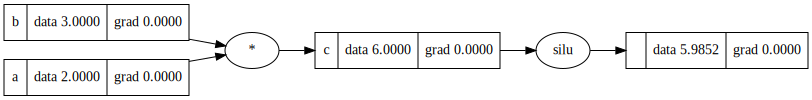

In [52]:
a = Tensor(2, label='a')
b = Tensor(3, label='b')

c = a * b; c.label = 'c'
d = F.silu_function(c)
draw_dot(d)

## Forward Section

In [54]:
import random

class Neuron:
    def __init__(self, input_size):
        self.weights = [[Tensor(random.uniform(-1, 1)) for i in range(5)] for _ in range(input_size)]
        self.ws = [Tensor(random.uniform(-1, 1)) for _ in range(input_size)]
        self.wb = [Tensor(random.uniform(-1, 1)) for _ in range(input_size)]

        self.bias = Tensor(random.uniform(-1, 1))

    def forward(self, x):
        t = [0, 0, 0, 0.33, 0.66, 1, 1, 1]
        if type(x) is not list:
          x = [x]
        for i in range(len(x)):
          if type(x[i]) is not Tensor :
            x[i] = Tensor(x[i])

        spline = [(F.deBoor_function(F.sigmoid_function(x_i), t, w_i, 2)) for w_i, x_i in zip(self.weights, x)]
        silu = [F.silu_function(x_i) for x_i in x]
        rr = Tensor(0)
        for i in range(len(spline)):
          rr = rr + spline[i]*self.ws[i] + silu[i]*self.wb[i]

        return rr + self.bias

    def __call__(self, x):
        return self.forward(x)

    def parameters(self):
        return [item for sublist in self.weights for item in sublist] + self.ws + self.wb + [self.bias]

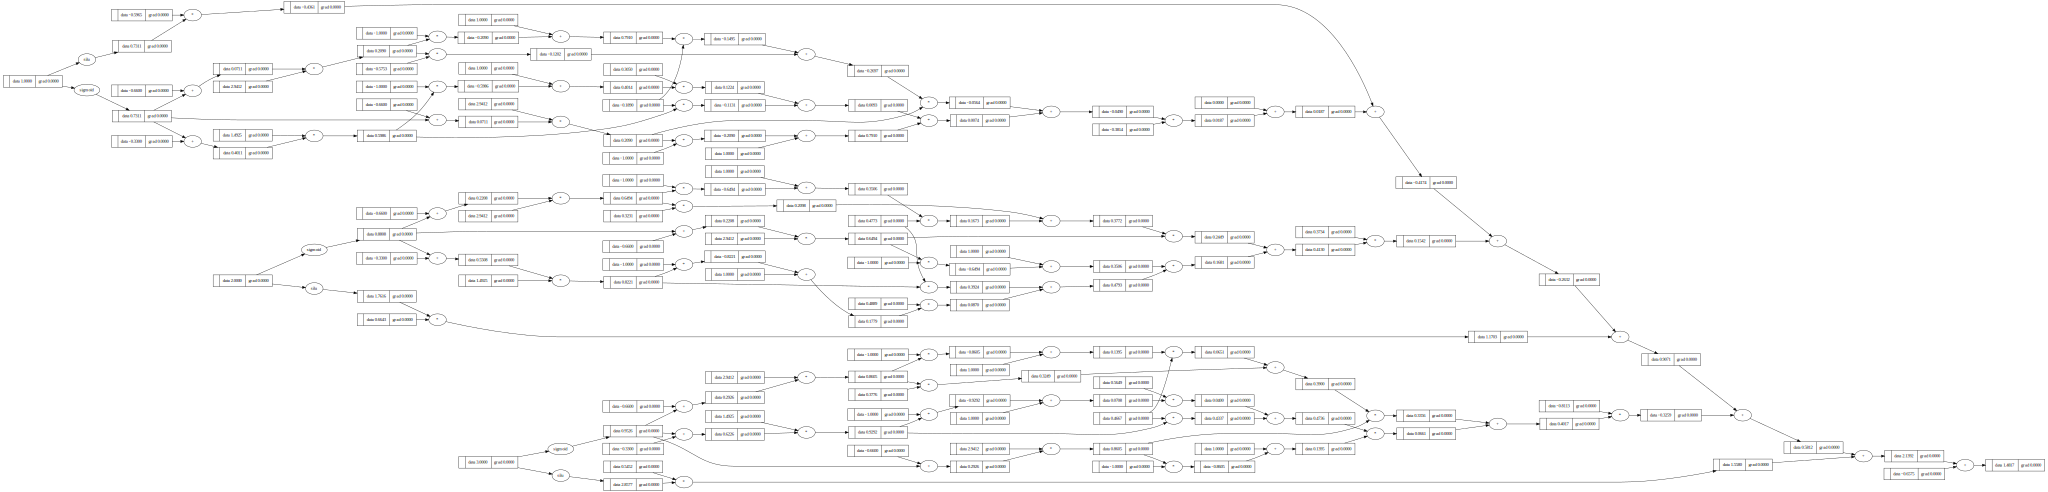

In [55]:
x = [1, 2, 3]
x = [Tensor(1), Tensor(2), Tensor(3)]

n = Neuron(3)
output = n(x)
draw_dot(output)

In [56]:
class Layer:

  def __init__(self, input_size, output_size):
    self.neurons = [Neuron(input_size) for _ in range(output_size)]

  def forward(self, x):
    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def __call__(self, x):
    return self.forward(x)

In [57]:
x = [Tensor(1), Tensor(2), Tensor(1), Tensor(2)]
l1 = Layer(3, 2)
l2 = Layer(2, 5)
l3 = Layer(5, 1)
output = l3(l2(l1(x)))
draw_dot(output)

In [43]:
class KAN:
    def __init__(self, input_size, layer_sizes):
        layers_total = [input_size] + layer_sizes
        self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __call__(self, x):
        return self.forward(x)

    def parameters(self):
        params = []
        for layer in self.layers:
            for neuron in layer.neurons:
                params.extend(neuron.parameters())
        return params

In [44]:
def compute_loss(y_hat, target):

    loss = (y_hat - target) ** 2
    loss.grad = 1

    return loss

In [45]:
class Optimizer:
    def __init__(self, lr=0.01):
        self.lr = lr

    def zero_grad(self, parameters):
        for param in parameters:
            param.grad = 0

    def step(self, parameters):
        for param in parameters:
            param.value -= self.lr * param.grad

In [46]:
x = [Tensor(1), Tensor(3), Tensor(4)]
input_size = len(x) # Number of features in the input layer
layer_sizes = [2, 3, 1] # Number of neurons in each hidden and output layer
model = KAN(input_size, layer_sizes)
output = model(x)
draw_dot(output)

## `grad_fn` in torch

In [59]:
n_epochs = 100
optim = Optimizer(lr=0.001)


x = [
    [Tensor(0.25), Tensor(0.25)],
    [Tensor(0.25), Tensor(0.75)],
    [Tensor(0.75), Tensor(0.25)],
    [Tensor(0.75), Tensor(0.75)]
]

x = [
    [0.25, 0.25],
    [0.25, 0.75],
    [0.75, 0.25],
    [0.75, 0.75]
]

y = [0.25, 0.75, 0.75, 0.25]
input_size = 2
layer_sizes = [2, 2, 2, 1]

kan = KAN(input_size, layer_sizes)

for _ in range(n_epochs):


    losses = Tensor(0)
    for _x, _y in zip(x, y):
      y_hat = kan(_x)
      loss = compute_loss(y_hat, _y)
      losses = loss + losses
    print('LOSS: ', losses)

    optim.zero_grad(kan.parameters())
    losses.grad = 1
    losses.backward()
    optim.step(kan.parameters())




draw_dot(y_hat)

LOSS:  Tensor(value=0.4684760862412532)
LOSS:  Tensor(value=0.4428609372971181)
LOSS:  Tensor(value=0.4100467641710853)
LOSS:  Tensor(value=0.3857006348613011)
LOSS:  Tensor(value=0.3693679705692392)
LOSS:  Tensor(value=0.3569807144089327)
LOSS:  Tensor(value=0.3426263901256971)
LOSS:  Tensor(value=0.33056051630191075)
LOSS:  Tensor(value=0.3216300840167945)
LOSS:  Tensor(value=0.31136348880307096)
LOSS:  Tensor(value=0.30443483419897477)
LOSS:  Tensor(value=0.29977672653550475)
LOSS:  Tensor(value=0.29331583435067005)
LOSS:  Tensor(value=0.28559078348086553)
LOSS:  Tensor(value=0.2813274616558471)
LOSS:  Tensor(value=0.2771771003196705)
LOSS:  Tensor(value=0.27284256728423484)
LOSS:  Tensor(value=0.26829313271183824)
LOSS:  Tensor(value=0.2661776348534811)
LOSS:  Tensor(value=0.2627837837537845)
LOSS:  Tensor(value=0.26002617386353644)
LOSS:  Tensor(value=0.2591338941708571)
LOSS:  Tensor(value=0.25813697926166507)
LOSS:  Tensor(value=0.25630519697746523)
LOSS:  Tensor(value=0.2549640